In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [17]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)


In [18]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [19]:
model_ae = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-3)

ae_losses = []

epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)

        x_hat, _ = model_ae(x)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f"AE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


AE Epoch [1/20], Loss: 0.0603
AE Epoch [2/20], Loss: 0.0476
AE Epoch [3/20], Loss: 0.0441
AE Epoch [4/20], Loss: 0.0423
AE Epoch [5/20], Loss: 0.0411
AE Epoch [6/20], Loss: 0.0403
AE Epoch [7/20], Loss: 0.0396
AE Epoch [8/20], Loss: 0.0391
AE Epoch [9/20], Loss: 0.0386
AE Epoch [10/20], Loss: 0.0383
AE Epoch [11/20], Loss: 0.0379
AE Epoch [12/20], Loss: 0.0377
AE Epoch [13/20], Loss: 0.0375
AE Epoch [14/20], Loss: 0.0372
AE Epoch [15/20], Loss: 0.0370
AE Epoch [16/20], Loss: 0.0368
AE Epoch [17/20], Loss: 0.0365
AE Epoch [18/20], Loss: 0.0365
AE Epoch [19/20], Loss: 0.0364
AE Epoch [20/20], Loss: 0.0362


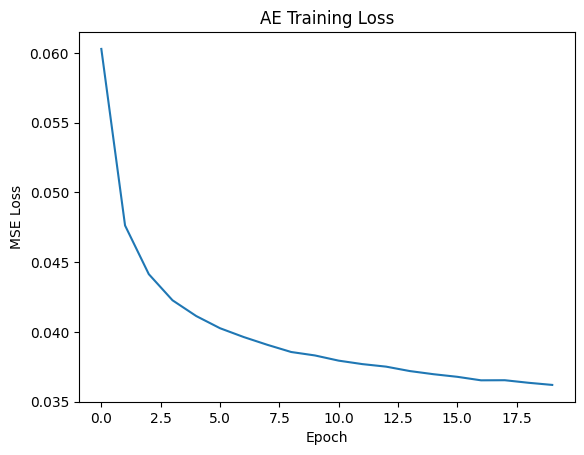

In [20]:
plt.plot(ae_losses)
plt.title("AE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


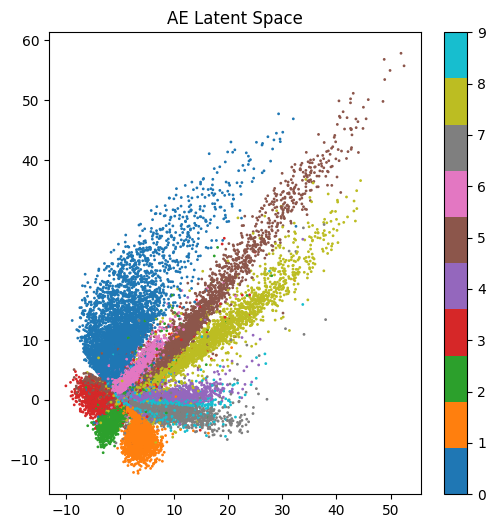

In [21]:
model_ae.eval()
latent = []
labels = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.view(-1, 784).to(device)
        _, z = model_ae(x)
        latent.append(z.cpu())
        labels.append(y)

latent = torch.cat(latent)
labels = torch.cat(labels)

plt.figure(figsize=(6,6))
plt.scatter(latent[:,0], latent[:,1], c=labels, cmap='tab10', s=1)
plt.colorbar()
plt.title("AE Latent Space")
plt.show()


In [22]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)

        self.mu = nn.Linear(128, 2)
        self.logvar = nn.Linear(128, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z


In [23]:
def vae_loss(x_hat, x, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl


In [24]:
model_vae = VAE().to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-3)

vae_losses, kl_losses = [], []

epochs = 30
for epoch in range(epochs):
    total_loss, total_kl = 0, 0

    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)

        x_hat, mu, logvar, _ = model_vae(x)
        loss, recon, kl = vae_loss(x_hat, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kl += kl.item()

    vae_losses.append(total_loss / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))

    print(f"VAE Epoch [{epoch+1}/{epochs}] Loss: {vae_losses[-1]:.2f} KL: {kl_losses[-1]:.2f}")


VAE Epoch [1/30] Loss: 6438.45 KL: 266.62
VAE Epoch [2/30] Loss: 5363.96 KL: 437.95
VAE Epoch [3/30] Loss: 5108.65 KL: 496.24
VAE Epoch [4/30] Loss: 4967.81 KL: 531.87
VAE Epoch [5/30] Loss: 4876.67 KL: 554.04
VAE Epoch [6/30] Loss: 4811.62 KL: 571.20
VAE Epoch [7/30] Loss: 4759.19 KL: 583.89
VAE Epoch [8/30] Loss: 4717.00 KL: 593.64
VAE Epoch [9/30] Loss: 4678.57 KL: 603.05
VAE Epoch [10/30] Loss: 4651.82 KL: 610.71
VAE Epoch [11/30] Loss: 4623.86 KL: 618.46
VAE Epoch [12/30] Loss: 4598.49 KL: 624.01
VAE Epoch [13/30] Loss: 4578.24 KL: 628.88
VAE Epoch [14/30] Loss: 4558.95 KL: 633.69
VAE Epoch [15/30] Loss: 4538.95 KL: 638.39
VAE Epoch [16/30] Loss: 4524.51 KL: 641.81
VAE Epoch [17/30] Loss: 4508.65 KL: 644.54
VAE Epoch [18/30] Loss: 4499.25 KL: 648.57
VAE Epoch [19/30] Loss: 4487.82 KL: 650.81
VAE Epoch [20/30] Loss: 4472.39 KL: 652.12
VAE Epoch [21/30] Loss: 4465.35 KL: 657.10
VAE Epoch [22/30] Loss: 4454.46 KL: 660.06
VAE Epoch [23/30] Loss: 4445.46 KL: 661.54
VAE Epoch [24/30] Lo

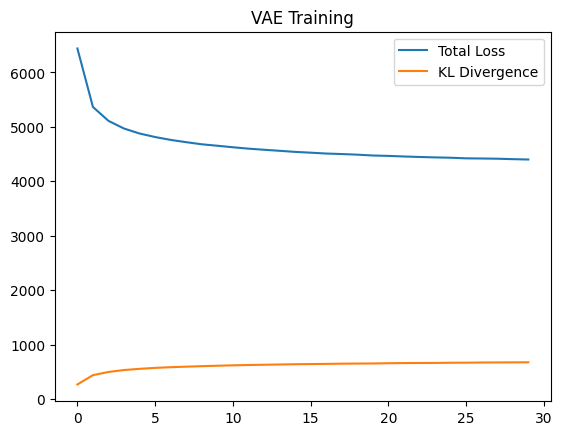

In [25]:
plt.plot(vae_losses, label="Total Loss")
plt.plot(kl_losses, label="KL Divergence")
plt.legend()
plt.title("VAE Training")
plt.show()


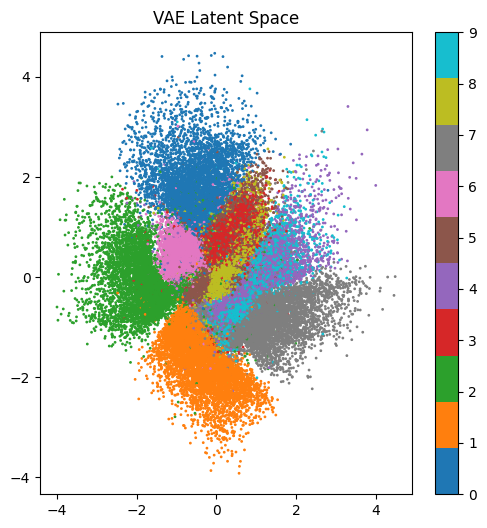

In [26]:
model_vae.eval()
latent, labels = [], []

with torch.no_grad():
    for x, y in train_loader:
        x = x.view(-1, 784).to(device)
        _, _, _, z = model_vae(x)
        latent.append(z.cpu())
        labels.append(y)

latent = torch.cat(latent)
labels = torch.cat(labels)

plt.figure(figsize=(6,6))
plt.scatter(latent[:,0], latent[:,1], c=labels, cmap='tab10', s=1)
plt.colorbar()
plt.title("VAE Latent Space")
plt.show()


In [35]:
import numpy as np
import struct
import torch
from torch.utils.data import Dataset, DataLoader
def load_idx_images(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows, cols)
    return images

def load_idx_labels(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels



In [36]:
train_images = load_idx_images(
    "/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte"
)

train_labels = load_idx_labels(
    "/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
)

test_images = load_idx_images(
    "/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
)

test_labels = load_idx_labels(
    "/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"
)

print(train_images.shape, train_labels.shape)


(60000, 28, 28) (60000,)


In [37]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) / 255.0
        img = torch.tensor(img).view(-1)   # 784
        label = int(self.labels[idx])
        return img, label


In [38]:
train_dataset = MNISTDataset(train_images, train_labels)
test_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)


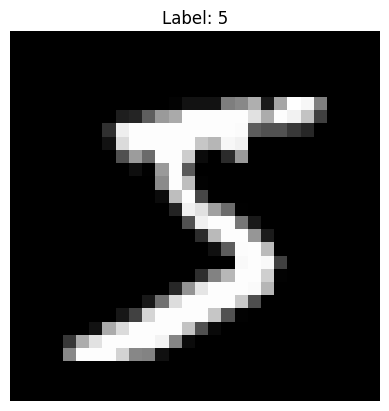

In [42]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]
plt.imshow(img.view(28,28), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [40]:
for x, y in train_loader:
    x = x.to(device)
    x_hat, z = model_ae(x)


In [43]:
x_hat, mu, logvar, z = model_vae(x)
train_dataset = MNISTDataset(train_images, train_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)


Démarrage de l'entraînement...
Epoch [1/50] D Loss: 0.2260 G Loss: 3.5483
Epoch [2/50] D Loss: 0.3644 G Loss: 6.4801
Epoch [3/50] D Loss: 0.3502 G Loss: 9.8003
Epoch [4/50] D Loss: 0.0522 G Loss: 4.6015
Epoch [5/50] D Loss: 0.0419 G Loss: 5.0158
Epoch [6/50] D Loss: 0.0097 G Loss: 7.0355
Epoch [7/50] D Loss: 0.0000 G Loss: 13.8533
Epoch [8/50] D Loss: 0.0001 G Loss: 14.1176
Epoch [9/50] D Loss: 0.0000 G Loss: 15.3625
Epoch [10/50] D Loss: 0.0000 G Loss: 15.4381
Epoch [11/50] D Loss: 0.0000 G Loss: 15.1008
Epoch [12/50] D Loss: 0.0001 G Loss: 16.2465
Epoch [13/50] D Loss: 0.0000 G Loss: 16.3390
Epoch [14/50] D Loss: 0.0000 G Loss: 16.7721
Epoch [15/50] D Loss: 0.0000 G Loss: 17.1976
Epoch [16/50] D Loss: 0.0000 G Loss: 17.1711
Epoch [17/50] D Loss: 0.0000 G Loss: 17.3514
Epoch [18/50] D Loss: 0.0000 G Loss: 17.4704
Epoch [19/50] D Loss: 0.0000 G Loss: 17.2557
Epoch [20/50] D Loss: 0.0000 G Loss: 17.7993
Epoch [21/50] D Loss: 0.0000 G Loss: 18.3845
Epoch [22/50] D Loss: 0.0000 G Loss: 16

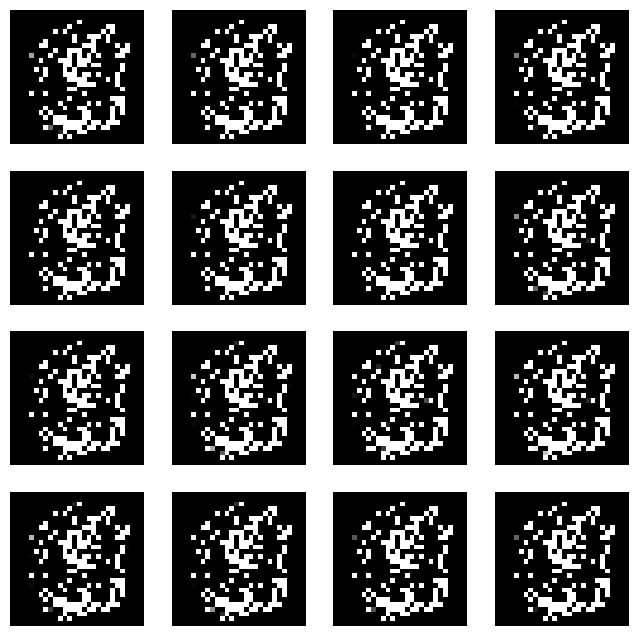

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Z_DIM = 100
MNIST_DIM = 784  # 28 * 28

# 1. Définition des Modèles corrigés pour MNIST
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Z_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, MNIST_DIM), # Sortie 784 pixels
            nn.Sigmoid() # Les pixels sont normalisés entre 0 et 1 (si vous utilisez BCELoss)
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(MNIST_DIM, 512), # Entrée 784 pixels (CORRECTION ICI)
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# 2. Initialisation
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
# Learning rates réduits pour plus de stabilité
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 3. Boucle d'entraînement
epochs = 50
G_losses, D_losses = [], []

print("Démarrage de l'entraînement...")

for epoch in range(epochs):
    for i, (real, _) in enumerate(train_loader):
        # Préparation des données réelles
        # Le dataloader retourne [batch, 784] grâce à votre classe MNISTDataset
        real = real.to(device) 
        batch_size = real.size(0)
        
        # Labels
        real_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        # --- Train Discriminator ---
        opt_D.zero_grad()
        
        # Perte sur images réelles
        outputs_real = D(real)
        d_loss_real = criterion(outputs_real, real_label)
        
        # Perte sur images fausses
        z = torch.randn(batch_size, Z_DIM).to(device)
        fake_images = G(z)
        outputs_fake = D(fake_images.detach()) # Detach pour ne pas entraîner G ici
        d_loss_fake = criterion(outputs_fake, fake_label)
        
        loss_D = d_loss_real + d_loss_fake
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        opt_G.zero_grad()
        
        # On veut tromper le discriminateur (on utilise real_label)
        outputs = D(fake_images)
        loss_G = criterion(outputs, real_label)
        
        loss_G.backward()
        opt_G.step()

    # Enregistrement et affichage
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    
    print(f"Epoch [{epoch+1}/{epochs}] D Loss: {loss_D.item():.4f} G Loss: {loss_G.item():.4f}")

# 4. Visualisation
with torch.no_grad():
    z = torch.randn(16, Z_DIM).to(device)
    generated = G(z).cpu().view(-1, 28, 28) 
    
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated[i], cmap='gray')
        plt.axis('off')
    plt.show()

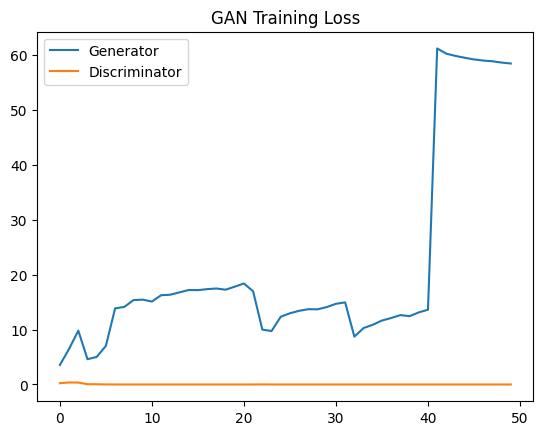

In [47]:
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.legend()
plt.title("GAN Training Loss")
plt.show()


In [48]:
z = torch.randn(16, 100).to(device)
fake = G(z).cpu()

grid = torchvision.utils.make_grid(fake, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()
